In [20]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature # Might not need this.

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

import tensorflow.keras as keras
import tensorflow as tf
print(tf.__version__)

2.0.0


In [2]:
# Load in data
trainImages = np.load('trnImage.npy')
trainLabels = np.load('trnLabel.npy')

testImages = np.load('tstImage.npy')
testLabels = np.load('tstLabel.npy')

testLabels = testLabels - 1
trainLabels = trainLabels -1

print(trainLabels.shape)

(10000, 1)


In [3]:
def computeFeatures(image):
    # This function computes the HOG features with the parsed hyperparameters and returns the features as hog_feature. 
    # By setting visualize=True we obtain an image, hog_as_image, which can be plotted for insight into extracted HOG features.
    hog_feature, hog_as_image = skimage.feature.hog(image, visualize=True, block_norm='L2-Hys')
    return hog_feature, hog_as_image

In [4]:
my_array = np.zeros((324, 10000))
my_test_array = np.zeros((324, 1000))
#labels_array = np.zeros(10000,)

for i in range(10000):
    features, hog_image = computeFeatures(trainImages[:,:,:,i])
    my_array[:, i] = features

for x in range(1000):
    features, hog_image = computeFeatures(testImages[:,:,:,x])
    my_test_array[:, x] = features
    
#for i in range(10000):
#    labels_array = trainLabels[i]

#print(my_array.shape)
#print(my_array)
#print(labels_array.shape)
#print(labels_array)

In [5]:
# Change the shape of the matrix

new_my_array = my_array.T
new_test_array = my_test_array.T

In [6]:
new_my_array.shape

(10000, 324)

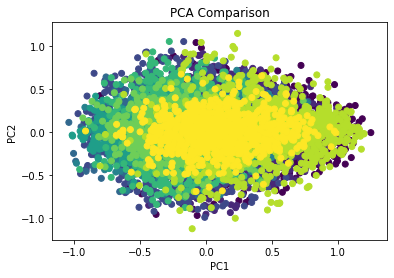

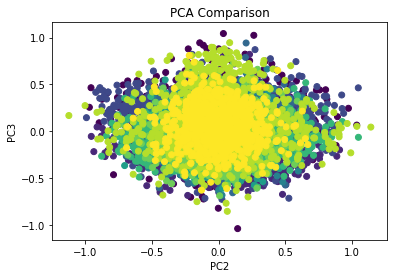

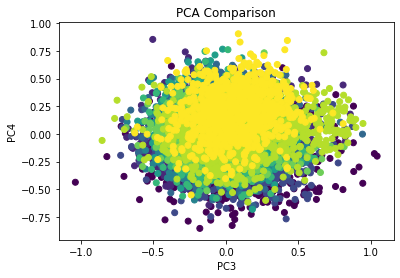

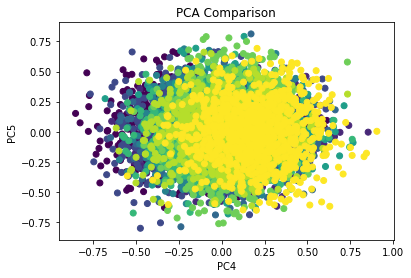

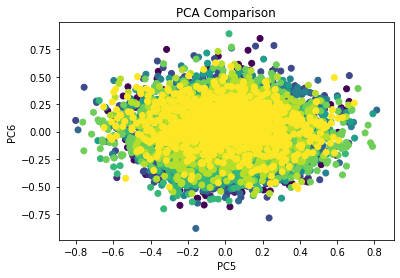

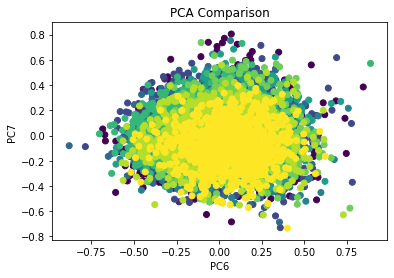

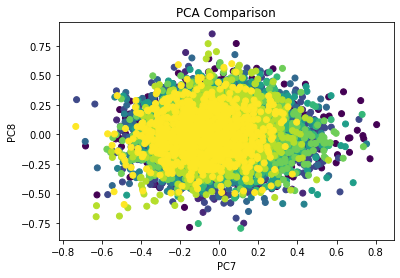

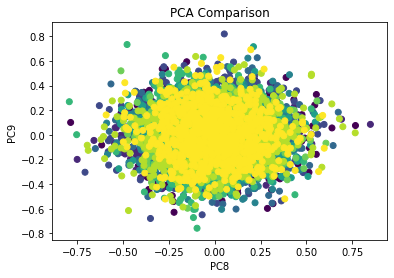

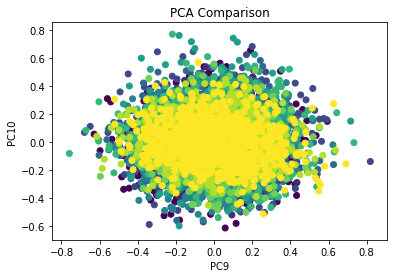

In [7]:
pca = PCA() #n_components = 40

pca.fit(new_my_array)

pca_train_data = pca.transform(new_my_array)


for i in range(9):
    plt.scatter(pca_train_data[:, i], pca_train_data[:, i+1], c=trainLabels.ravel())
    plt.xlabel('PC'+ str(i+1))
    plt.ylabel('PC'+ str(i+2))
    plt.title('PCA Comparison')
    plt.show()

pca.fit(new_test_array)

pca_test_data = pca.transform(new_test_array)

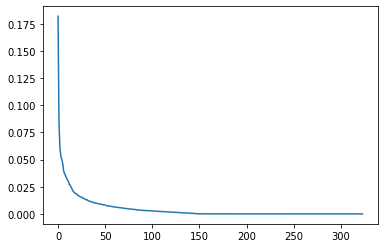

In [8]:
plt.plot(pca.explained_variance_)

In [9]:
# Training the Neural Net with PCA
number_of_classes = 10

# Build our network architecture by stacking layers in a Keras Sequential object.
model = keras.Sequential()

# Create the input layer, this takes an argument of the input data shape (i.e. number of features)
model.add(keras.layers.InputLayer(input_shape=(pca_train_data.shape[1],)))

# Create hidden layers
model.add(keras.layers.Dense(45, activation='sigmoid')) # first layer
model.add(keras.layers.Dense(45, activation='sigmoid')) # second layer
model.add(keras.layers.Dense(10, activation='sigmoid')) # third layer

# Create output layer to get predicted class labels.
model.add(keras.layers.Dense(number_of_classes, activation='softmax'))

# Generate a callable keras Model object which contains our architecture.
# This allows us to train and predict our neural network on the datasets.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc']) #play around with differnt optimizer

# Fit our model to the data
history = model.fit(pca_train_data, trainLabels, validation_data=(pca_test_data, testLabels), epochs=400, verbose=0)

# Predict probabilities of classes for the testing set.
predicted_probabilities = model.predict(pca_test_data)

# Use argmax to get the predicted class label
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Calculate the percentage accuracy rate on test set
accuracy = np.sum(np.equal(testLabels, predicted_labels.reshape(-1,1)))/ 1000 * 100
print('Percentage accuracy on testing set is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set is: 16.10%


In [ ]:
accuracy = np.sum(np.equal(testLabels, predicted_labels.reshape(-1,1)))/ 1000 * 100
print(' accuracy = ',accuracy,' %')

In [ ]:
#predicted_labels.reshape(-1,1)

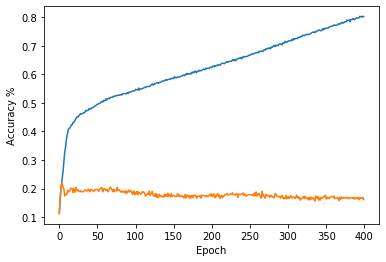

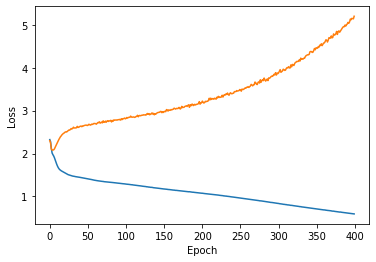

In [10]:
# Plot the training curves for model accuracy
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')

# Plot the training curves for the model's loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Using LDA and feeding through a NN

(324, 10000)
(324,)


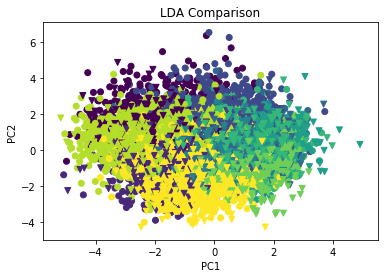

In [11]:
LDA = LinearDiscriminantAnalysis() #n_components=40

print(my_array.shape)
print(features.shape)
#print(labels_array)

LDA.fit(new_my_array, trainLabels.ravel())

lda_new_train_data = LDA.transform(new_my_array)

plt.scatter(lda_new_train_data[:, 0], lda_new_train_data[:, 1], c=trainLabels.ravel())
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('LDA Comparison')


LDA.fit(new_test_array, testLabels.ravel())

lda_new_test_data = LDA.transform(new_test_array)

plt.scatter(lda_new_test_data[:, 0], lda_new_test_data[:, 1], c=testLabels.ravel(), marker='v')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('LDA Comparison')
plt.show()

In [18]:
# Training the Neural Net with LDA
number_of_classes = 10

# Build our network architecture by stacking layers in a Keras Sequential object.
model = keras.Sequential()

# Create the input layer, this takes an argument of the input data shape (i.e. number of features)
model.add(keras.layers.InputLayer(input_shape=(lda_new_train_data.shape[1],)))

# Create hidden layers
model.add(keras.layers.Dense(70, activation='sigmoid')) # first layer
model.add(keras.layers.Dense(70, activation='sigmoid')) # second layer
model.add(keras.layers.Dense(70, activation='sigmoid')) # third layer

# Create output layer to get predicted class labels.
model.add(keras.layers.Dense(number_of_classes, activation='softmax'))

# Generate a callable keras Model object which contains our architecture.
# This allows us to train and predict our neural network on the datasets.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc']) #play around with differnt optimizer

# Fit our model to the data
history = model.fit(lda_new_train_data, trainLabels, validation_data=(lda_new_test_data, testLabels), epochs=400, verbose=0)

# Predict probabilities of classes for the testing set.
predicted_probabilities = model.predict(lda_new_test_data)

# Use argmax to get the predicted class label
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Calculate the percentage accuracy rate on test set
accuracy = np.sum(np.equal(testLabels, predicted_labels.reshape(-1,1)))/ 1000 * 100
print('Percentage accuracy on testing set is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set is: 31.60%


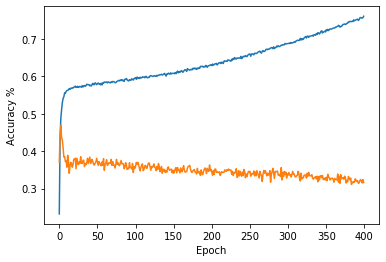

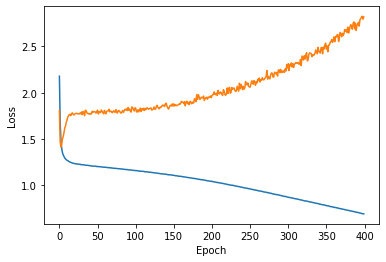

In [19]:
# Plot the training curves for model accuracy
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')

# Plot the training curves for the model's loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## SVM and NN

In [25]:
C = 1 # This is the penalty of the error term (Lecture 8, slide 18). 
model = SVC(kernel='poly', C=C)

# Normalise the data based on the training set
normaliser = StandardScaler().fit(new_my_array)
train_data = normaliser.transform(new_my_array)
test_data = normaliser.transform(new_test_array)


# Plot the training samples, then plot the testing samples with different marker shapes.
#plt.scatter(train_data[:, 0], train_data[:, 1], marker='o', c=train_labels)
#plt.scatter(test_data[:, 0], test_data[:, 1], marker='x', c=test_labels)
#plt.xlabel('Feature 1')
#plt.ylabel('Feature 2')
#plt.title('Train/Test split of feature space')
#plt.show()
accuracy = np.sum(np.equal(testLabels, predicted_labels.reshape(-1,1)))/ 1000 * 100
print('Percentage accuracy on testing set is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set is: 31.60%


In [15]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [24]:
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(new_my_array, trainLabels).predict(new_test_array)


def plot_confusion_matrix(y_true, y_pred, classes):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #if not title:
    #    if normalize:
    #        title = 'Normalized confusion matrix'
    #    else:
    #        title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    #if normalize:
    #    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           #title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(new_test_array, y_pred, classes=testLabels)

# Plot normalized confusion matrix
#plot_confusion_matrix(new_test_array, y_pred, classes=testLabels,
#                      title='Normalized confusion matrix')

plt.show()

/Users/Andy/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Classification metrics can't handle a mix of continuous-multioutput and multiclass targets